---
**Dataset:** *Coral reef global bleaching*


**Objective:** *Predict reef bleaching*

**Author:** *Danylo Zemskyi, Omari March*

**Date:** *15/12/2025*

---

## 1. Introduction

### 1.1 Problem Statement

* Description of the task: Bleaching prediction for Coral Reef Global Bleaching dataset (Population wide).
* Target variable: This problem is about predicting how much coral bleaching occurs (measured as Percent Bleaching) based on environmental and physical factors like water depth, temperature, distance from shore, exposure, turbidity, and cyclone frequency (Regression problem).
* Topic relevance: Coral reefs play a vital role in marine ecosystem health. Coral reefs are able to support diverse ecosystems, filter the water, and create oxygen when they have clean, clear, and cool water to support them. Also, they protect shorelines by reducing the impact from waves, storms, and floods. This helps prevent loss of life, property damage, and erosion. When reefs are damaged or destroyed, coastal communities can suffer increased damage from severe storms, and even normal wave action. Bleached corals continue to live, but they are more vulnerable to disease and starvation.

### 1.2 Dataset Overview

* Source of the dataset: https://www.kaggle.com/datasets/mehrdat/coral-reef-global-bleaching
* Number of samples and features: The dataset consists of 2 csv files, which have 18 and 62 Features, and 41361 rows each. Csv file with 62 features provides a lot of redundant metrics that can be derived with formulas. Both files can be merged by Sample_ID column
* Feature types (numerical, categorical, target)


## 2. Experimental Setup

### 2.1 Libraries

Used libs
numpy
pandas

matplotlib
seaborn
os

sklearn
statsmodels
scipy

xgboost
tensorflow.keras

### 2.2 Evaluation Metrics

* Metrics used: R2 and MAE
* Justification: MAE is preferred in tasks involving skewed or outlier-prone data because it provides a robust, scale-consistent measure of average model error without disproportionately penalizing large deviations.
	As the baseline model mean predictor was chosen, which can give a sense what is the minimal mean absolute error model has to archive to be better than a simple mean model (MAEbaseline = 11.29).
	R2 provides an interpretable measure of overall model fit and how well the model captures data patterns relative to a naive mean-based predictor, which is picked as baseline performance.

### 2.3 Dataset split

* Split method used: train-test split(TTS)
* TTS chosen over k-fold cross-validation as the dataset is sufficiently large to minimize overfitting risks associated with TTS, while significantly reducing computational cost by requiring only a single model training instead of multiple iterations.




In [2]:

"""Data manipulations libs"""
import numpy as np
import pandas as pd

"""Plotting libs"""
import matplotlib.pyplot as plt
import seaborn as sns
import os

"""Models evaluations imports"""
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

"""Data preprocessing imports"""
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew, boxcox


"""Dataset stats imports"""
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeRegressor

"""Models that were used imports"""
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, Dropout, ReLU, Add
)
from tensorflow.keras.callbacks import EarlyStopping

## 3. Baseline Model


### 3.1 Baseline Definition

Since this the task involves regression for Percent_Bleaching prediction, the baseline performance can be assessed using simple models such as the mean predictor or median predictor, which always predict the average or median bleaching percentage across the dataset. That will provide us with a reference level of performance to compare more complex models against.

### 3.2 Baseline Results

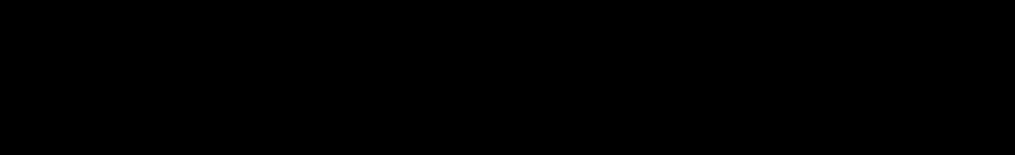

In [3]:
path = "./coral-reef-global-bleaching"
filename_read = os.path.join(path, "coral_whole.csv")

df = pd.read_csv(filename_read)

df  = df.drop(columns=['Sample_ID', 'Percent_Cover', 'Date_Year']) #Percent_Cover has 30% of its row NA, so it significantly cuts dataset
df.dropna(inplace=True)


df.info()
print(df)

<class 'pandas.core.frame.DataFrame'>
Index: 32714 entries, 0 to 35044
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cyclone_Frequency    32714 non-null  float64
 1   Depth_m              32714 non-null  float64
 2   ClimSST              32714 non-null  float64
 3   Ocean_Name           32714 non-null  object 
 4   Country_Name         32714 non-null  object 
 5   Distance_to_Shore    32714 non-null  float64
 6   Exposure             32714 non-null  object 
 7   Turbidity            32714 non-null  float64
 8   Bleaching_Level      32714 non-null  object 
 9   Temperature_Maximum  32714 non-null  float64
 10  SSTA                 32714 non-null  float64
 11  TSA                  32714 non-null  float64
 12  Percent_Bleaching    32714 non-null  float64
 13  Temperature_Mean     32714 non-null  float64
 14  Realm_Name           32714 non-null  object 
dtypes: float64(10), object(5)
memory usage: 4

In [4]:
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = [col for col in df.columns if col not in num_cols]

target_value_col = "Percent_Bleaching"

In [5]:
# Target value
y = df[target_value_col].to_list()

# Mean prediction
y_median = np.median(y)
y_mean = np.mean(y)

y_pred_median = np.full(len(y), y_median)
y_pred_mean = np.full(len(y), y_mean)

# Metrics Median
mae_median = mean_absolute_error(y, y_pred_median)
rmse_median = root_mean_squared_error(y, y_pred_median)
r2_median = r2_score(y, y_pred_median)

print("Median Baseline Results:")
print(f"MAE: {mae_median:.4f}")
print(f"RMSE: {rmse_median:.4f}")
print(f"R: {r2_median:.4f}")

# Metrics Mean
mae_mean = mean_absolute_error(y, y_pred_mean)
rmse_mean = root_mean_squared_error(y, y_pred_mean)
r2_mean = r2_score(y, y_pred_mean)

print("\nMean Baseline Results:")
print(f"MAE: {mae_mean:.4f}")
print(f"RMSE: {rmse_mean:.4f}")
print(f"R: {r2_mean:.4f}")



Median Baseline Results:
MAE: 8.0678
RMSE: 19.8756
R: -0.1973

Mean Baseline Results:
MAE: 11.2953
RMSE: 18.1646
R: 0.0000


## 4. Exploratory Data Analysis (EDA)

### 4.1 Target Distribution

Histogram shows that target value has a lot of outliers and extremely skewed around 0%, which implies that Percent_Bleaching values has to be scaled to mitigate impact of imbalance distribution and normalized. Nevertheless, The histogram highlights a fundamental difference between population-level and colony-level bleaching observations. Population-level measurements provide a broad, aggregated indication of overall bleaching severity across reef sites, whereas colony-level observations capture finer-scale variability and extreme responses at the individual colony level. Because these two data types represent different ecological scales and statistical distributions, training a single model on both would conflate distinct processes and potentially bias predictions. Therefore, separate models are required to accurately capture bleaching dynamics at each observational scale.

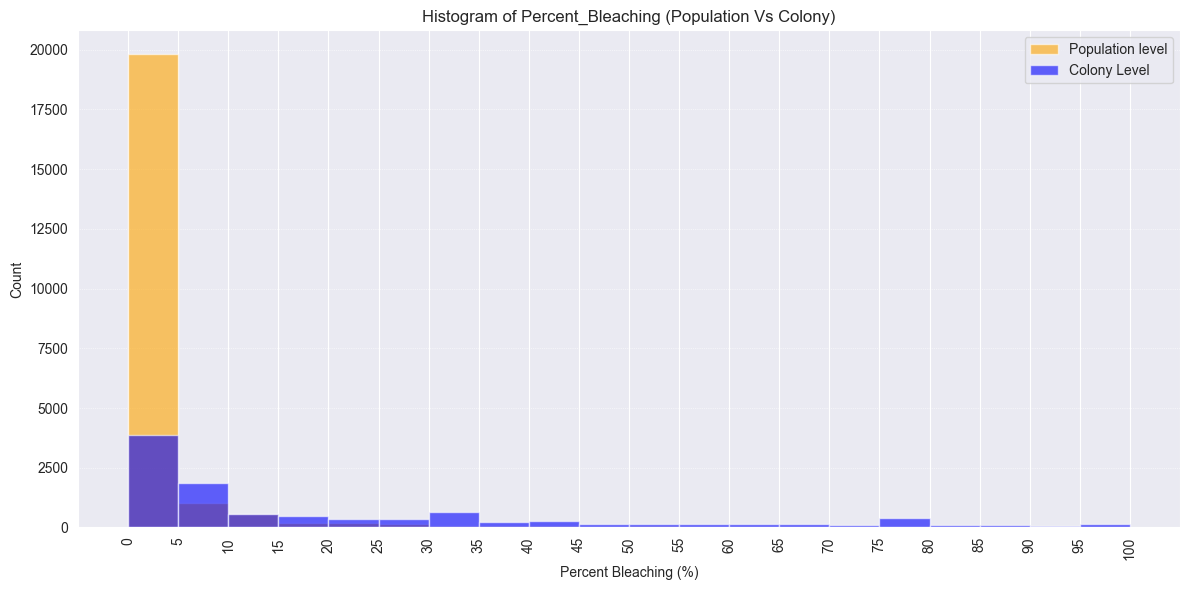

In [6]:
# Create boolean masks to separate samples with and without bleaching

df_population = df[df["Bleaching_Level"] != "Colony"]
df_colony = df[df["Bleaching_Level"] != "Population"]

bins = np.arange(0, 105, 5)  # from 0 to 100 in steps of 0.5

# Generate bin labels (not directly used in plotting)
labels = [f"{b}–{b+5}%" for b in bins[:-1]]

# Plot histogram for no bleaching samples
plt.figure(figsize=(12, 6))
plt.hist(
    df_population[target_value_col],
    bins=bins,
    color="orange",
    alpha=0.6,
    edgecolor=None,
    label="Population level"
)

# Plot histogram for samples with bleaching
plt.hist(
    df_colony[target_value_col],
    bins=bins,
    color="blue",
    alpha=0.6,
    edgecolor=None,
    label="Colony Level"
)
plt.xticks(bins)
plt.xlabel("Percent Bleaching (%)")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Histogram of Percent_Bleaching (Population Vs Colony)")
plt.grid(axis="y", linestyle=":", linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()



### 4.2 Feature Distribution and Skewness

The majority of numerical features in the dataset exhibit pronounced skewness, with several key variables showing strong right-skew (e.g., Distance_to_Shore, Turbidity, Percent_Bleaching) and others displaying left-skewed distributions (e.g., ClimSST, Temperature_Mean, TSA), indicating non-normal feature distributions and further motivating the use of transformation and non-linear modeling approaches.


In [7]:

def get_skewness(df, num_cols):
    skewness_results = {}

    # Iterate through numerical columns
    for col in num_cols:
        numeric_data = df[col]

          # Compute skewness only if the column contains data
        if len(numeric_data) > 0:
            skew_val = skew(numeric_data)

            # Store skewness value and categorize its type
            skewness_results[col] = {
                'skewness': skew_val,
                'skew_type': 'Right (Positive)' if skew_val > 0.5 else 'Left (Negative)' if skew_val < -0.5 else 'Approximately Symmetric',

            }

    # Convert and sort results to a DataFrame for easier inspection
    skewness_df = pd.DataFrame(skewness_results).T
    skewness_df = skewness_df.sort_values('skewness', key=abs, ascending=False)

    print(skewness_df[:-1])
    return skewness_results


skewness_results = get_skewness(df, num_cols)

                     skewness         skew_type
Distance_to_Shore    9.390477  Right (Positive)
Turbidity            3.848336  Right (Positive)
Percent_Bleaching    2.969849  Right (Positive)
ClimSST             -1.640544   Left (Negative)
Temperature_Mean    -1.320474   Left (Negative)
Depth_m              1.272371  Right (Positive)
TSA                 -1.013456   Left (Negative)
Temperature_Maximum  0.930379  Right (Positive)
Cyclone_Frequency    0.891588  Right (Positive)


### 4.3 Feature Relationships

The Pearson correlation matrix shows generally weak linear relationships among the environmental variables and between predictors and the target variable (Percent_Bleaching). Most correlation coefficients are close to zero, indicating limited linear dependence.

<Axes: >

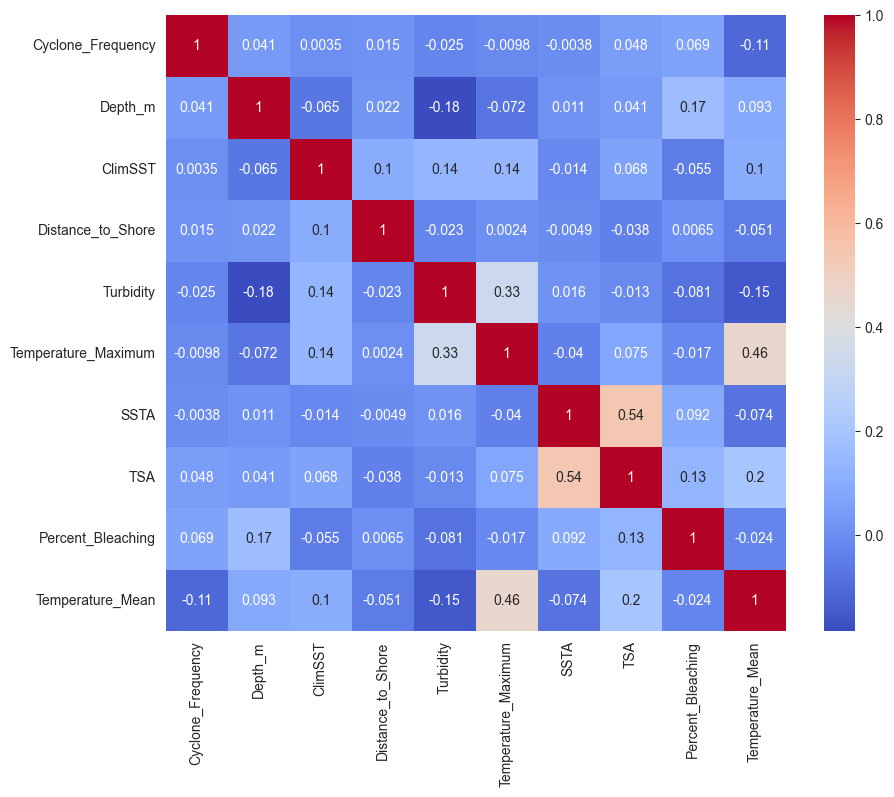

In [8]:

df_numeric = df[num_cols]

pearson_corr_matrix = df_numeric.corr(method="pearson")

features = pearson_corr_matrix.index

# Use Heatmap to visualize matrix
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr_matrix, annot=True, cmap="coolwarm")

The Spearman correlation matrix reveals stronger monotonic relationships than those observed with Pearson correlation, indicating that several variables are related in a non-linear but monotonic manner.

<Axes: >

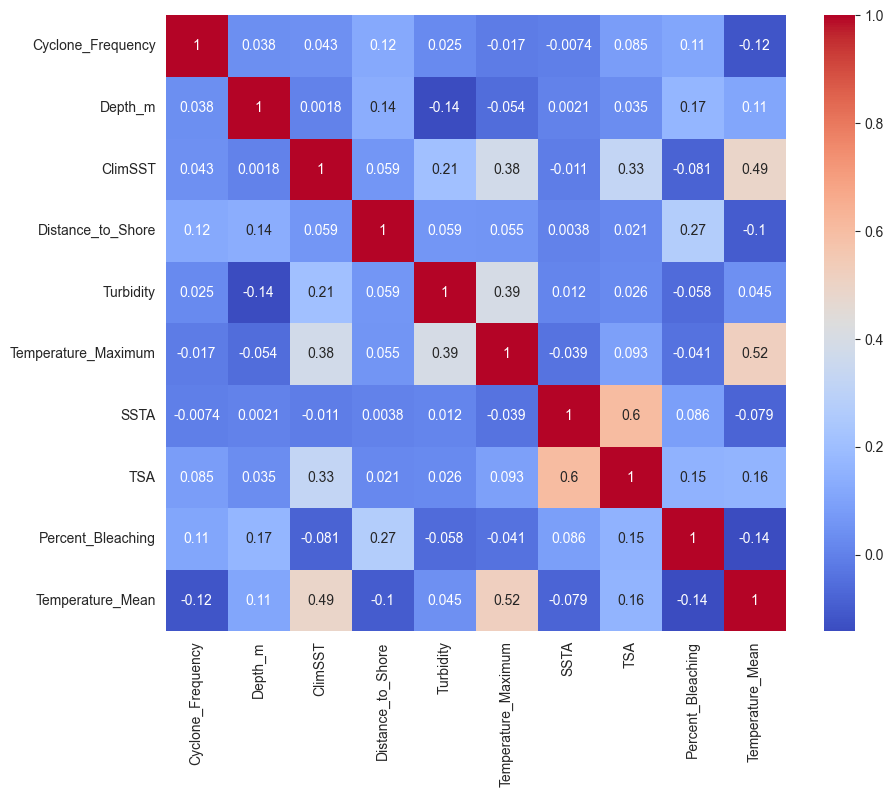

In [9]:
spearman_corr_matrix = df_numeric.corr(method="spearman")
features = spearman_corr_matrix.index

# Use Heatmap to visualize matrix
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap="coolwarm")

The VIF analysis reveals severe multicollinearity among temperature-related variables (Temperature_Mean and ClimSST), confirming strong feature redundancy and motivating the use  non-linear models that are less sensitive to collinearity.

In [10]:
vif_data = pd.DataFrame()

# Add numerical feature names
vif_data["features"] = num_cols

# Compute VIF for each numerical feature by regressing it against all other features
vif_data["vif"] = [
    variance_inflation_factor(df_numeric.values, i)
    for i in range(len(num_cols))
]

vif_data


,features,vif
0,Cyclone_Frequency,51.860955
1,Depth_m,4.060596
2,ClimSST,411.180812
3,Distance_to_Shore,1.109021
4,Turbidity,3.253969
5,Temperature_Maximum,55534.515475
6,SSTA,1.607220
7,TSA,2.062368
8,Percent_Bleaching,1.270236
9,Temperature_Mean,54902.395242


Mutual information regression was used to quantify the non-linear dependency between each numerical feature and the target variable, Percent Bleaching. Unlike correlation-based measures, mutual information captures both linear and non-linear relationships without assuming monotonicity. The results indicate that Distance to Shore, Cyclone Frequency, and temperature-related variables exhibit the strongest non-linear associations with bleaching severity, while Depth shows a comparatively weaker influence. As expected, the target variable itself ranks highest, serving as a validation of the method.


In [58]:
mi_X = df_numeric.drop(target_value_col, axis=1)
mi_X.drop(["Temperature_Maximum", "ClimSST"], axis=1, inplace=True)


## Compute mutual information scores between each numerical feature and the target variable
mi = mutual_info_regression(mi_X, y)
mi_scores = pd.Series(mi, index=mi_X.columns).sort_values(ascending=False)

mi_scores

Distance_to_Shore    0.810055
Cyclone_Frequency    0.738986
Temperature_Mean     0.619202
Turbidity            0.617324
TSA                  0.446706
SSTA                 0.371517
Depth_m              0.178166
dtype: float64

Overall, the dataset exhibits non-linear relationships, significant feature redundancy, skewed feature distributions, and interaction effects, pushing the use of scaled non-linear models and ensemble methods for robust prediction.


## 5. Data Preprocessing

Before selecting feature set it is better to see the effect of categorical data on DecisionTreeRegressor(), since they carry a lot of environmental data

In [12]:
def test_model(model, X_test, y_test, plot_title = ""):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"R2 score for {plot_title}: {r2}")
    print(f"MAE score for {plot_title}: {mae}")

    residuals = y_test - y_pred

    # Plot residuals vs predicted
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals Plot for {plot_title}")
    plt.show()


In [19]:
path = "./coral-reef-global-bleaching"
filename_read = os.path.join(path, "coral_whole.csv")

df_tmp = pd.read_csv(filename_read)


# Percent_Cover tells how much of a corals were observed. This is irrelevant predictor, so its removed
df_population = df_tmp.drop(columns=['Sample_ID', 'Percent_Cover','Date_Year'])

# Split Population samples from Colony
df_population = df_population[df_population['Bleaching_Level'] != 'Colony']
df_population.drop("Bleaching_Level", axis=1, inplace=True)

df_population.dropna(inplace=True)


df_colony = df_tmp.drop(columns=['Sample_ID', 'Percent_Cover', 'Date_Year'])
# Split Population samples from Colony
df_colony = df_colony[df_colony['Bleaching_Level'] != 'Population']
df_colony.drop("Bleaching_Level", axis=1, inplace=True)

df_colony.dropna(inplace=True)

df_tmp.info()
df_population.info()
df_colony.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41361 entries, 0 to 41360
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sample_ID            41361 non-null  int64  
 1   Cyclone_Frequency    41361 non-null  float64
 2   Depth_m              39562 non-null  float64
 3   ClimSST              41248 non-null  float64
 4   Ocean_Name           41361 non-null  object 
 5   Country_Name         41360 non-null  object 
 6   Distance_to_Shore    41359 non-null  float64
 7   Exposure             41361 non-null  object 
 8   Turbidity            41355 non-null  float64
 9   Date_Year            41361 non-null  int64  
 10  Bleaching_Level      41361 non-null  object 
 11  Temperature_Maximum  41229 non-null  float64
 12  SSTA                 41213 non-null  float64
 13  TSA                  41213 non-null  float64
 14  Percent_Bleaching    34515 non-null  float64
 15  Temperature_Mean     41229 non-null 


### 5.1 Handle N/A

NEED TO BE DONE


### 5.2 Encoding & Transformation and Feature Scaling

To address the skewness observed in the numerical features, skewness-aware transformations were applied to create a normalized version of the dataset. Right-skewed variables were transformed using the Box–Cox transformation after ensuring strictly positive values with a small shift for zero-values, while left-skewed variables were normalized using the Yeo–Johnson power transformation, which supports negative values. All transformations were applied to a separate normalized dataset to preserve the original data, improving distributional symmetry and supporting more stable and effective training of scale-sensitive models.


In [20]:
def normalize_df(df, skewness_results):

    df_normalized = df.copy()

    # Identify right- and left-skewed features based on skewness thresholds
    right_skewed = {col: data for col, data in skewness_results.items() if data['skewness'] > 0.5}
    left_skewed  = {col: data for col, data in skewness_results.items() if data['skewness'] < -0.5}

    # Display skewed feature names for inspection
    print(left_skewed.keys())
    print(right_skewed.keys())

    # Apply Box–Cox transformation to right-skewed features
    # Replace zeros to ensure strictly positive values
    for col_right in right_skewed.keys():
        df_normalized[col_right] = df_normalized[col_right].replace(0, 1e-6)
        df_normalized[col_right], lam = boxcox(df_normalized[col_right])

    # Apply Yeo–Johnson transformation to left-skewed features
    for col_left in left_skewed.keys():
        pt = PowerTransformer(method='yeo-johnson')
        df_normalized[[col_left]] = pt.fit_transform(df_normalized[[col_left]])

    # Return normalized dataset
    return df_normalized

In [15]:
# Compute skewness for numerical features in both dataset variants
skewness_results_population = get_skewness(df_population, num_cols)
skewness_results_colony = get_skewness(df_colony, num_cols)

# Apply skewness-based normalization to each dataset
df_normalized_population = normalize_df(df_population, skewness_results_population)
df_normalized_colony = normalize_df(df_colony, skewness_results_colony)

                     skewness         skew_type
Distance_to_Shore     8.25337  Right (Positive)
Percent_Bleaching    6.039517  Right (Positive)
Turbidity            3.646717  Right (Positive)
ClimSST             -1.782021   Left (Negative)
Temperature_Mean     -1.13808   Left (Negative)
Cyclone_Frequency    1.024807  Right (Positive)
TSA                 -0.995497   Left (Negative)
Temperature_Maximum  0.920973  Right (Positive)
Depth_m              0.515233  Right (Positive)
                     skewness                skew_type
Distance_to_Shore    8.600762         Right (Positive)
Cyclone_Frequency    0.654981         Right (Positive)
Depth_m                   NaN  Approximately Symmetric
ClimSST                   NaN  Approximately Symmetric
Turbidity                 NaN  Approximately Symmetric
Temperature_Maximum       NaN  Approximately Symmetric
SSTA                      NaN  Approximately Symmetric
TSA                       NaN  Approximately Symmetric
Percent_Bleaching        

C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


dict_keys([])
dict_keys(['Cyclone_Frequency', 'Distance_to_Shore'])


Categorical and numerical features were processed separately: categorical variables were encoded using one-hot encoding to convert them into a numerical representation, while numerical features were standardized to zero mean and unit variance. Scaling was applied even after normalization to ensure comparable feature magnitudes, which is particularly important for distance-based and gradient-based models. Finally, the processed numerical and categorical features were combined into a single feature matrix used for model training and evaluation.

In [16]:
def get_preprocessed_split_data(df):
    # Determine usable columns directly from the dataset
    cat_used = [c for c in cat_cols if c in df.columns]
    num_used = [c for c in num_cols if c in df.columns]
    num_used.remove(target_value_col)

    # Split first (no leakage)
    X = df.drop(columns=[target_value_col])
    y = df[target_value_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # We do one_hot_encode for categorical features
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    X_train_cat = ohe.fit_transform(X_train[cat_used])
    X_test_cat  = ohe.transform(X_test[cat_used])
    X_cat = ohe.transform(X[cat_used])

    # Retrieve names of one-hot encoded categorical features
    ohe_feature_names = ohe.get_feature_names_out(cat_used)

    # We scale the numeric features
    scaler = StandardScaler()

    # Even after normalization its still crucial to scale-up data
    X_train_num = scaler.fit_transform(X_train[num_used])
    X_test_num  = scaler.transform(X_test[num_used])
    X_num = scaler.transform(X[num_used])


    # Combine the categorical and numerical features
    X_processed = np.hstack([X_num, X_cat])
    X_train_processed = np.hstack([X_train_num, X_train_cat])
    X_test_processed  = np.hstack([X_test_num, X_test_cat])

    # Store final processed feature names in correct order
    processed_feature_names = np.concatenate([num_used, ohe_feature_names])

     # Return processed data and metadata as dictionary
    return {
    "X_processed": X_processed,
    "y": y,
    "X_train": X_train_processed,
    "X_test": X_test_processed,
    "y_train": y_train,
    "y_test": y_test,
    "feature_names": processed_feature_names
}

In [72]:
data_population = get_preprocessed_split_data(df_normalized_population)
data_colony = get_preprocessed_split_data(df_normalized_colony)


## 6. Support Vector Machines (SVM)

### 6.1 Motivation for SVM

Support Vector Machines (SVM) were initially selected due to their conceptual simplicity, strong theoretical grounding, and flexibility in modelling both linear and non-linear relationships through a variety of kernel functions. This versatility makes SVMs powerful in many structured prediction tasks.

### 6.2 Kernel Experiments

#### 6.2.1 RBF Kernel




In [30]:
model_svr_population = SVR(kernel="rbf", shrinking=True, tol=0.001)
model_svr_colony = SVR(kernel="rbf", shrinking=True, tol=0.001)

model_svr_population.fit(data_population["X_train"], data_population["y_train"])
model_svr_colony.fit(data_colony["X_train"], data_colony["y_train"])

SVR()

R2 score for SVM (kernel = rbf) Population samples: -0.10052265328554144
MAE score for SVM (kernel = rbf) Population samples: 12.977106208067426


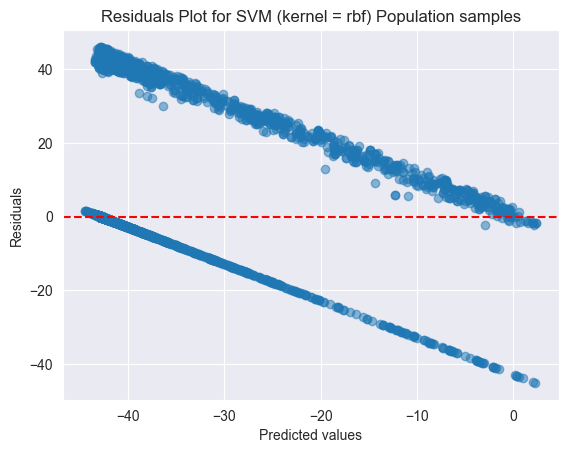

In [31]:
test_model(model_svr_population, data_population["X_test"], data_population["y_test"], "SVM (kernel = rbf) Population samples")

R2 score for SVM (kernel = rbf) Colony samples: 0.45944950832638587
MAE score for SVM (kernel = rbf) Colony samples: 1.9511419047402585


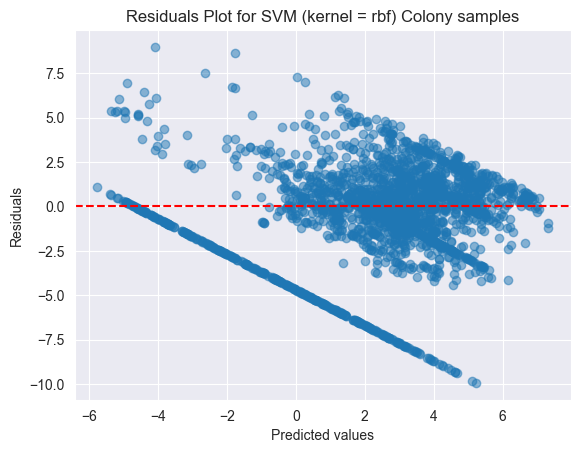

In [32]:
test_model(model_svr_colony, data_colony["X_test"], data_colony["y_test"], "SVM (kernel = rbf) Colony samples")

#### 6.2.2 Polynomial Kernel (degree 2)



In [33]:
model_svr_population = SVR(kernel="poly", degree=2, shrinking=True, tol=0.001)
model_svr_colony = SVR(kernel="poly", degree=2, shrinking=True, tol=0.001)

model_svr_population.fit(data_population["X_train"], data_population["y_train"])
model_svr_colony.fit(data_colony["X_train"], data_colony["y_train"])

SVR(degree=2, kernel='poly')

R2 score for SVM (kernel = poly, degree 2) Population samples: -0.10711533657425476
MAE score for SVM (kernel = poly, degree 2) Population samples: 12.95647472235132


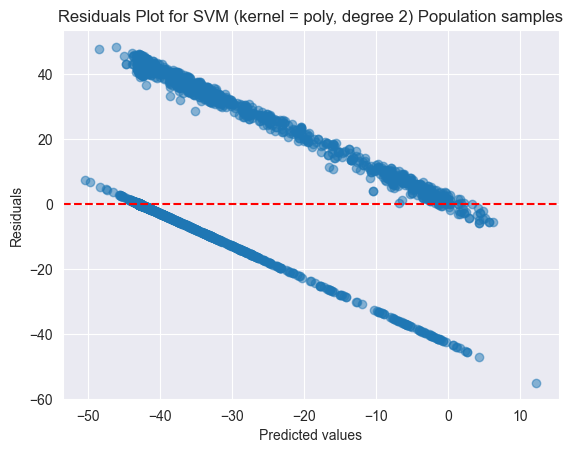

In [34]:
test_model(model_svr_population, data_population["X_test"], data_population["y_test"], "SVM (kernel = poly, degree 2) Population samples")

R2 score for SMV (kernel = poly, degree 2) Colony samples: 0.41298742870239835
MAE score for SMV (kernel = poly, degree 2) Colony samples: 2.0945768241210456


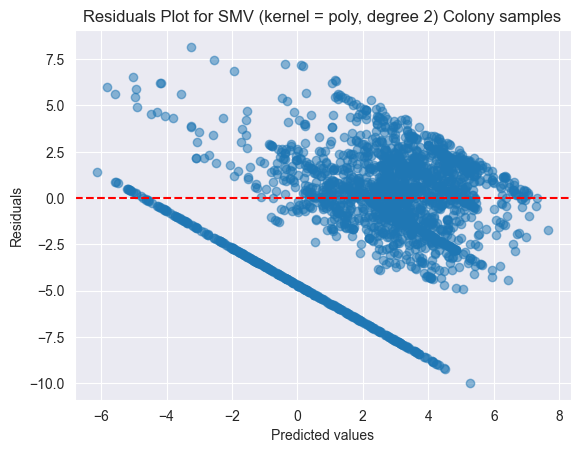

In [35]:
test_model(model_svr_colony, data_colony["X_test"], data_colony["y_test"], "SMV (kernel = poly, degree 2) Colony samples")

#### 6.2.3 Polynomial Kernel (degree 3)

In [36]:
model_svr_population = SVR(kernel="poly", degree=3, shrinking=True, tol=0.001)
model_svr_colony = SVR(kernel="poly", degree=3, shrinking=True, tol=0.001)

model_svr_population.fit(data_population["X_train"], data_population["y_train"])
model_svr_colony.fit(data_colony["X_train"], data_colony["y_train"])

SVR(kernel='poly')

R2 score for SVM (kernel = poly, degree = 3) Population samples: -0.11598387566725576
MAE score for SVM (kernel = poly, degree = 3) Population samples: 12.945670495765407


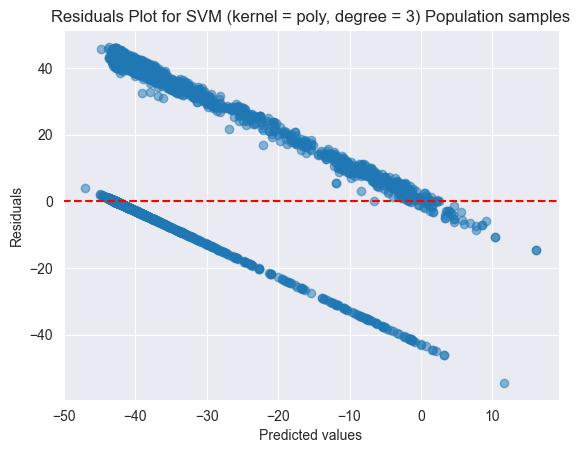

In [37]:
test_model(model_svr_population, data_population["X_test"], data_population["y_test"], "SVM (kernel = poly, degree = 3) Population samples")

R2 score for SVM (kernel = poly, degree = 3) Colony samples: 0.45657526613573396
MAE score for SVM (kernel = poly, degree = 3) Colony samples: 1.9720529051448406


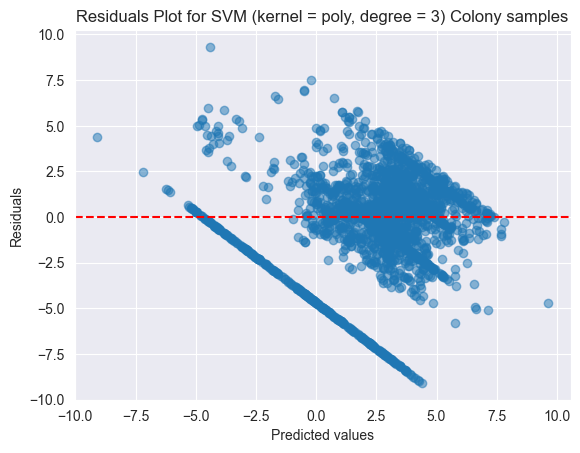

In [38]:
test_model(model_svr_colony, data_colony["X_test"], data_colony["y_test"], "SVM (kernel = poly, degree = 3) Colony samples")

### 6.3 SVM Results Comparison

 SVMs showed persistent scalability limitations when applied to our dataset. Training non-linear kernels was computationally expensive, making large-scale tuning impractical.

Additionally, SVMs are sensitive to multicollinearity, which can distort the margin geometry and lead to unstable predictions. For this reason, only some experiments were selected for SVMs.




## 7. Ensemble Tree Models

A feature importance analysis was conducted using a Decision Tree Regressor to quantify the contribution of each predictor to the model’s performance. Importance scores were aggregated at the base-feature level to account for one-hot encoded categorical variables, and features exceeding a predefined importance threshold were selected as the most influential predictors


In [40]:
def get_base_feature(feature_name):
    for col in list(num_cols) + list(cat_cols):
        # Handles one-hot encoded names like Country_Name_Australia
        if feature_name == col or feature_name.startswith(col + "_"):
            return col
    return feature_name  # fallback


def tree_feature_importance(X, y, processed_feature_names, threshold=0.01, model=None):

    # If no tree based model is provided, train a default Decision Tree regressor
    if model is None:
        model = DecisionTreeRegressor()
        model.fit(X, y)


    importance = model.feature_importances_

    # Create a DataFrame pairing each processed feature with its importance score and sort by
    importance_df = pd.DataFrame({
        "feature": processed_feature_names,
        "importance": importance
    }).sort_values("importance", ascending=False)

    # Map each processed (possibly one-hot encoded) feature back to its base feature
    importance_df["base_feature"] = importance_df["feature"].apply(get_base_feature)

    # Aggregate importance scores by base feature
    # This sums contributions from all one-hot encoded levels of categorical variables
    grouped_importance = (
        importance_df
        .groupby("base_feature")["importance"]
        .sum()
        .sort_values(ascending=False)
    )

    # Select base features whose aggregated importance exceeds the given threshold
    selected_features_tree = [
        f for f, s in zip(grouped_importance.index, grouped_importance.values)
        if s > threshold
    ]

    # Print selected features and full aggregated importance table for inspection
    print(f"Selected features for trees: {selected_features_tree}")
    print(grouped_importance)

    # Append the target variable so the returned dataset remains model-ready
    selected_features_tree.append(target_value_col)

    return selected_features_tree


In [41]:
selected_features_tree_population = tree_feature_importance(data_population["X_processed"], data_population["y"], data_population["feature_names"])
selected_features_tree_colony = tree_feature_importance(data_colony["X_processed"], data_colony["y"], data_colony["feature_names"])

Selected features for trees: ['SSTA', 'TSA', 'Depth_m', 'ClimSST', 'Distance_to_Shore', 'Country_Name', 'Temperature_Mean', 'Cyclone_Frequency', 'Turbidity', 'Ocean_Name', 'Exposure']
base_feature
SSTA                   0.137796
TSA                    0.135678
Depth_m                0.113496
ClimSST                0.111744
Distance_to_Shore      0.109781
Country_Name           0.101061
Temperature_Mean       0.087548
Cyclone_Frequency      0.080149
Turbidity              0.072430
Ocean_Name             0.030220
Exposure               0.017357
Realm_Name             0.002741
Temperature_Maximum    0.000000
Name: importance, dtype: float64
Selected features for trees: ['Country_Name', 'TSA', 'Depth_m', 'ClimSST', 'Temperature_Mean', 'Distance_to_Shore', 'SSTA', 'Turbidity', 'Cyclone_Frequency', 'Realm_Name', 'Ocean_Name']
base_feature
Country_Name           0.208359
TSA                    0.159478
Depth_m                0.103634
ClimSST                0.098062
Temperature_Mean       0.08

### 7.1 Model Selection

Random Forest and XGBoost were selected as advanced ensemble learning methods to evaluate their capacity to model complex, non-linear relationships within the dataset. Both methods provide robust predictive performance, strong generalization, and built-in mechanisms to handle feature interactions, making them well-suited for heterogeneous environmental datasets. Their ability to capture non-linear patterns without extensive feature engineering motivated their use after simpler baseline models demonstrated limited effectiveness.




### 7.2 Initial Ensemble Training

In [42]:
tree_data_population = get_preprocessed_split_data(df_normalized_population[selected_features_tree_population])
tree_data_colony = get_preprocessed_split_data(df_normalized_colony[selected_features_tree_colony])

In [44]:
xgb_model_population = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.3,
    min_child_weight=1,
    gamma=0, # No need to add penalty since there is enough samples
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
)
xgb_model_colony = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.3,
    min_child_weight=1,
    gamma=0, # No need to add penalty since there is enough samples
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
)


xgb_model_population.fit(tree_data_population["X_train"], tree_data_population["y_train"])
xgb_model_colony.fit(tree_data_colony["X_train"], tree_data_colony["y_train"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, ...)

R2 score for XGBoost Population samples: 0.8002086274804117
MAE score for XGBoost Population samples: 3.338258927194978


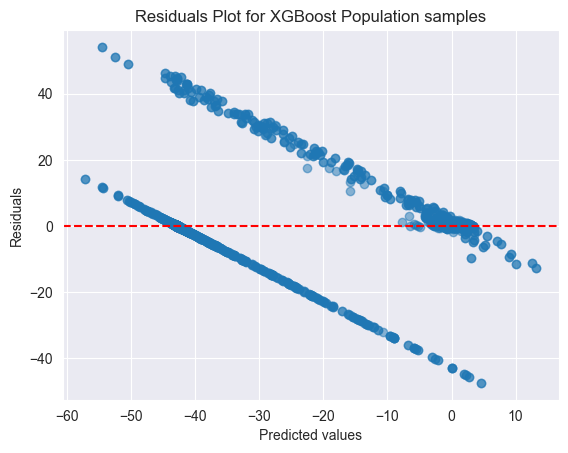

In [45]:
test_model(xgb_model_population, tree_data_population["X_test"], tree_data_population["y_test"], "XGBoost Population samples")

R2 score for XGBoost Colony samples: 0.6731522079143061
MAE score for XGBoost Colony samples: 1.3147107905368947


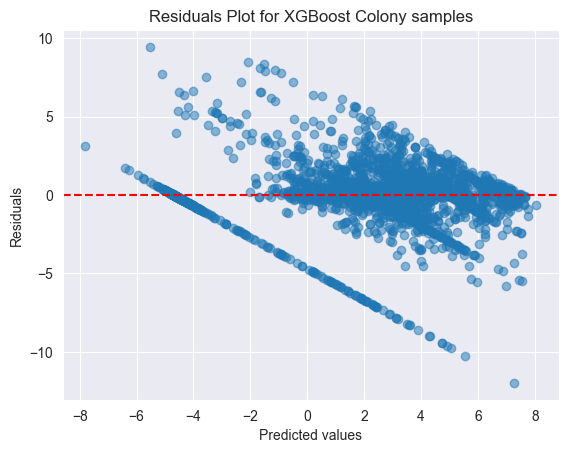

In [46]:
test_model(xgb_model_colony, tree_data_colony["X_test"], tree_data_colony["y_test"], "XGBoost Colony samples")

In [47]:
rf_model_population = RandomForestRegressor(
    n_estimators=600,
    max_depth=30,
    criterion="friedman_mse",
    max_features=0.5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.,
    bootstrap=False,
    random_state=42,
    n_jobs=-1)

rf_model_colony = RandomForestRegressor(
    n_estimators=600,
    max_depth=30,
    criterion="friedman_mse",
    max_features=0.5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.,
    bootstrap=False,
    random_state=42,
    n_jobs=-1)

rf_model_population.fit(tree_data_population["X_train"], tree_data_population["y_train"])
rf_model_colony.fit(tree_data_colony["X_train"], tree_data_colony["y_train"])

RandomForestRegressor(bootstrap=False, criterion='friedman_mse', max_depth=30,
                      max_features=0.5, n_estimators=600, n_jobs=-1,
                      random_state=42)

R2 score for Randon Forest Population samples: 0.8250785521088468
MAE score for Randon Forest Population samples: 2.9308356707758336


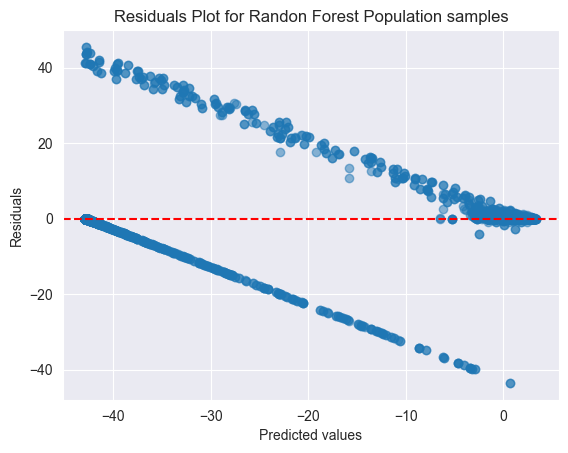

In [48]:
test_model(rf_model_population, tree_data_population["X_test"], tree_data_population["y_test"], "Randon Forest Population samples")

R2 score for Randon Forest Population samples: 0.7230847149212956
MAE score for Randon Forest Population samples: 1.1774459476721206


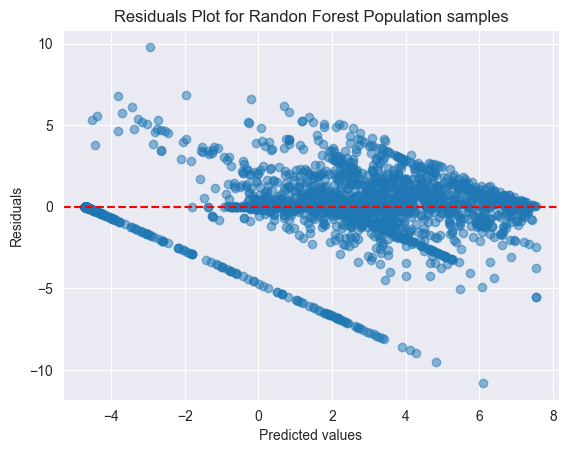

In [49]:
test_model(rf_model_colony, tree_data_colony["X_test"], tree_data_colony["y_test"], "Randon Forest Population samples")

### 7.4 Hyperparameter Refinement

Further feature refinement was not performed, as the selected feature set already demonstrated strong performance.

In [50]:
refined_features_tree_population = tree_feature_importance(tree_data_population["X_processed"], tree_data_population["y"], tree_data_population["feature_names"], threshold=0.02, model=rf_model_population)

refined_features_tree_colony = tree_feature_importance(tree_data_colony["X_processed"], tree_data_colony["y"], tree_data_colony["feature_names"], threshold=0.02, model=rf_model_colony)

refined_tree_data_population = get_preprocessed_split_data(df_normalized_population[refined_features_tree_population])
refined_tree_data_colony = get_preprocessed_split_data(df_normalized_colony[refined_features_tree_colony])

Selected features for trees: ['TSA', 'SSTA', 'Depth_m', 'Distance_to_Shore', 'Country_Name', 'ClimSST', 'Temperature_Mean', 'Cyclone_Frequency', 'Turbidity', 'Ocean_Name']
base_feature
TSA                  0.136264
SSTA                 0.127938
Depth_m              0.116572
Distance_to_Shore    0.115149
Country_Name         0.113312
ClimSST              0.112374
Temperature_Mean     0.090794
Cyclone_Frequency    0.074657
Turbidity            0.070371
Ocean_Name           0.025648
Exposure             0.016920
Name: importance, dtype: float64
Selected features for trees: ['TSA', 'Country_Name', 'Temperature_Mean', 'Depth_m', 'ClimSST', 'Distance_to_Shore', 'SSTA', 'Cyclone_Frequency', 'Turbidity', 'Realm_Name']
base_feature
TSA                  0.163293
Country_Name         0.151945
Temperature_Mean     0.112533
Depth_m              0.109743
ClimSST              0.097284
Distance_to_Shore    0.086525
SSTA                 0.081324
Cyclone_Frequency    0.081286
Turbidity            0.0750

In [51]:
refined_xgb_model_population = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.3,
    min_child_weight=1,
    gamma=0,  # No need to add penalty since there is enough samples
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
)
refined_xgb_model_colony = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.3,
    min_child_weight=1,
    gamma=0,  # No need to add penalty since there is enough samples
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
)

refined_xgb_model_population.fit(refined_tree_data_population["X_train"], refined_tree_data_population["y_train"])
refined_xgb_model_colony.fit(refined_tree_data_colony["X_train"], refined_tree_data_colony["y_train"])


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, ...)

R2 score for Refined XGBoost Population samples: 0.8117284226642525
MAE score for Refined XGBoost Population samples: 3.2087071306569053


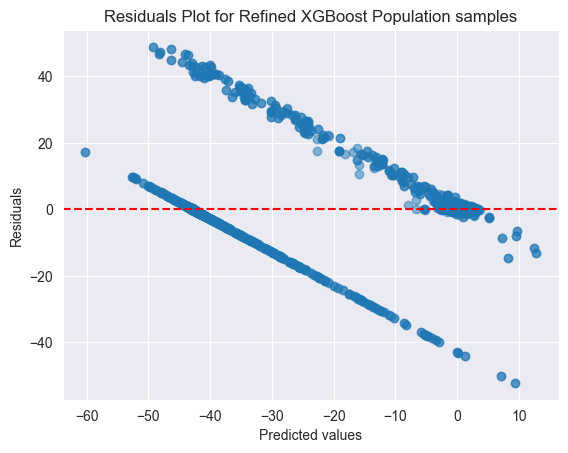

In [52]:
test_model(refined_xgb_model_population, refined_tree_data_population["X_test"], refined_tree_data_population["y_test"], "Refined XGBoost Population samples")

R2 score for Refined XGBoost Colony samples: 0.6708169667873849
MAE score for Refined XGBoost Colony samples: 1.3260237243165856


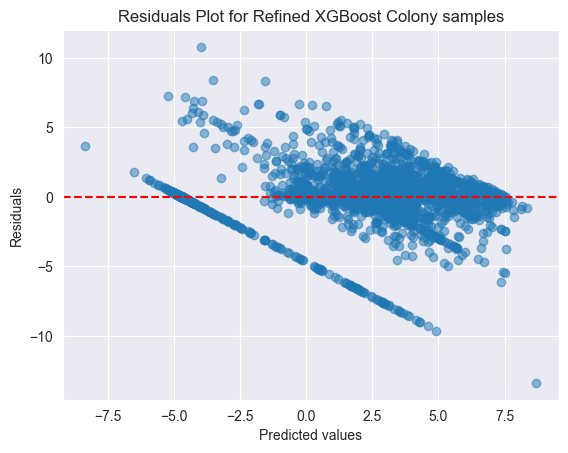

In [53]:
test_model(refined_xgb_model_colony, refined_tree_data_colony["X_test"], refined_tree_data_colony["y_test"], "Refined XGBoost Colony samples")

In [54]:
refined_rf_model_population = RandomForestRegressor(
    n_estimators=600,
    max_depth=30,
    criterion="friedman_mse",
    max_features=0.5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.,
    bootstrap=False,
    random_state=42,
    n_jobs=-1)

refined_rf_model_colony = RandomForestRegressor(
    n_estimators=600,
    max_depth=30,
    criterion="friedman_mse",
    max_features=0.5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.,
    bootstrap=False,
    random_state=42,
    n_jobs=-1)

refined_rf_model_population.fit(refined_tree_data_population["X_train"], refined_tree_data_population["y_train"])
refined_rf_model_colony.fit(refined_tree_data_colony["X_train"], refined_tree_data_colony["y_train"])

RandomForestRegressor(bootstrap=False, criterion='friedman_mse', max_depth=30,
                      max_features=0.5, n_estimators=600, n_jobs=-1,
                      random_state=42)

R2 score for Refined Randon Forest Population samples: 0.8258625426750983
MAE score for Refined Randon Forest Population samples: 2.9267831643303386


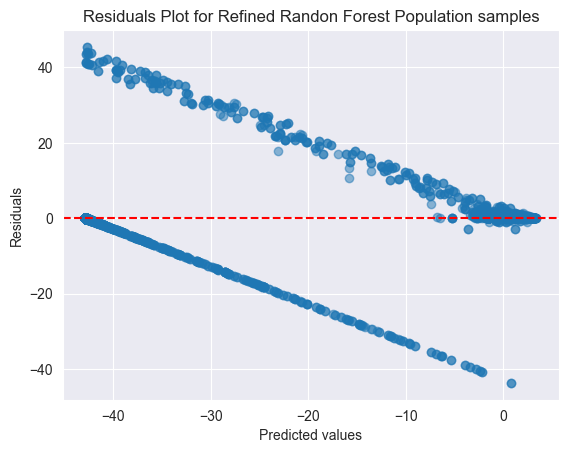

In [55]:
test_model(refined_rf_model_population, refined_tree_data_population["X_test"], refined_tree_data_population["y_test"], "Refined Randon Forest Population samples")

R2 score for Refined Randon Forest Population samples: 0.7221369591396212
MAE score for Refined Randon Forest Population samples: 1.1804715879119658


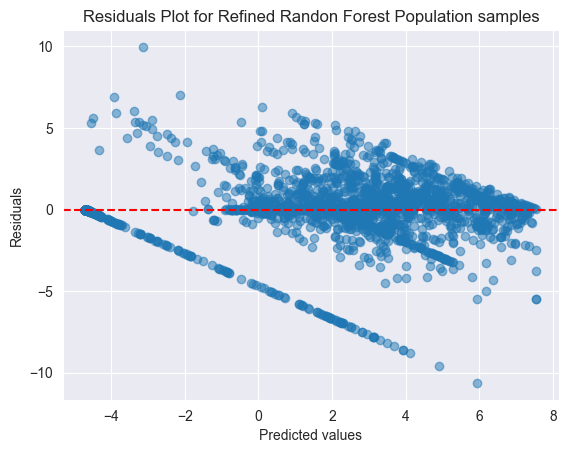

In [56]:
test_model(refined_rf_model_colony, refined_tree_data_colony["X_test"], refined_tree_data_colony["y_test"], "Refined Randon Forest Population samples")

### 7.5 Ensemble Results

Random Forest demonstrated the most robust performance, achieving the lowest MAE and stable R2, especially in the presence of numerous high-bleaching outliers. Its architecture of aggregated decision trees made it less sensitive to noise and better able to approximate the real distribution of extreme bleaching values.
	XGBoost delivered similarly strong results and showed superior performance within the main cluster of bleaching values. It benefited more from feature engineering than Random Forest, improving significantly after removing weak or correlated predictors. However, XGBoost tended to make fewer but larger errors, making it slightly less reliable in the outlier-heavy tail of the target distribution.


## 9. Deep Neural Networks (DNN)

### 9.1 Motivation for DNN

* Non-linearity handling
* High-dimensional interactions

### 9.2 Data Scaling for DNN

```python
# Scaling for neural networks
```

### 9.3 Model Architecture

* Number of layers
* Activation functions
* Regularization methods


### 9.4 Training & Optimization

* Loss function
* Optimizer
* Early stopping

### 9.5 DNN Performance

* Training vs validation curves
* Final evaluation metrics

---

## 10. Conclusions

### 10.1. Final Model Selection

- **Selected model**
Ensemble tree-based models (Random Forest and XGBoosting) were selected as the final models.
The dataset exhibits  non-linear relationships, complex interactions between environmental and geographic variables, and pronounced skewness with outliers. Ensemble tree methods handle these characteristics effectively, as they do not rely on distance-based metrics or gradient optimization that can be distorted by extreme values. In contrast, SVMs and deep neural networks showed higher sensitivity to feature scaling, skewness, and extreme observations, resulting in less stable performance.

- **Strengths and weaknesses**
The main strengths of ensemble trees include robustness to outliers, the ability to implicitly capture feature interactions without explicit feature engineering, and consistent generalization across different dataset variants. Their primary limitations are reduced interpretability compared to linear models and higher computational cost relative to simpler approaches, particularly when training large ensembles.

### 10.2. Key Findings

* Causal structure (DAG) for coral bleaching analysis:

```text
   Geography ---> Human Impact ---> Bleaching
        |              |                ∧
        |              ∨                |
        --------> Environment -----------
```

   **Geography** (e.g., distance to shore, ocean, country, depth) affects:
        - Human impact (population, fishing, pollution)
        - Environmental conditions (temperature, turbidity, light, currents)
        - Bleaching directly through natural ecological pathways

   **Human impact** also influences the environment (e.g., pollution, sedimentation), creating indirect effects on bleaching.

   To estimate the causal effect Human Impact -> Bleaching, geographic variables must be included as controls to block backdoor paths.

* Model Behavior: Support Vector Machines (SVM)

  **Scalability issues:** SVMs performed very poorly on large datasets. Training was extremely time-consuming and computationally expensive, making large-scale tuning impractical.
  **Sensitivity to multicollinearity:** The presence of highly correlated features distorted the margin geometry, resulting in unstable predictions.
  **Skewed target distribution:** SVM struggled with the heavily imbalanced Percent_Bleaching values, particularly underestimating extreme bleaching events.


* Model Behavior: Ensemble Tree Models (Random Forest & XGBoost)

    **Random Forest**

    **Robust to outliers:** Handles extreme Percent_Bleaching values well, producing more frequent but smaller errors (lower MAE).
    **Insensitive to feature selection:** Maintains stable performance even when weak or correlated predictors are removed.
    **Captures non-linear interactions:** Effectively models complex relationships between environmental and geographic variables without explicit feature engineering.
    **Computational considerations:** Training time increases with many categorical features (e.g., Realm_Name), but removing these features significantly improves efficiency.

    **XGBoost**

    **Error characteristics:** Produces fewer but larger errors, making extreme bleaching predictions slightly less reliable.
    **High predictive capability:** Achieves strong performance within the main cluster of bleaching values (0–35%).
    **Sensitive to feature engineering:** Shows larger gains from removing weak or correlated predictors compared to Random Forest.

### 10.3 Limitations

* Imbalanced data: The dataset is highly imbalanced, with a disproportionate number of non-bleaching reefs compared to fewer bleaching and severely bleached observations, which add bias toward majority patterns and makes accurate modeling of extreme bleaching events more challenging.

* Multicollinearity: Temperature-related variables (Temperature_Mean, Temperature_Maximum, ClimSST) and other correlated features exhibit high variance inflation factors (VIFs), potentially destabilizing models that assume independent predictors.

### 10.4 Future Improvements

* Feature engineering: Introduce explicit interaction terms, threshold-based features, and categorical embeddings - based on tree feature importance and permutations scores - to help deep neural networks better capture non-linear and conditional relationships in the data.

* More data:
Scraping the data sources referenced in the dataset documentation to collect additional observations, improving coverage and model generalization for moderate and severe bleached reef.

* Model tuning:
Exploit the temporal structure of the dataset by transitioning from feedforward DNNs to sequence models such as RNNs or LSTMs to better capture time-dependent bleaching dynamics. Also apply some feature engineering based on tree feature importance and permutations scores.

## 11. Appendix

### 11.1 Hyperparameters

### 11.2 Additional Plots

### 11.3 Reproducibility Notes
